In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.layers import Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,GRU
from keras.models import Sequential
import tensorflow as tf
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
%matplotlib inline
import seaborn as sns
import sys
sns.set_style("whitegrid")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plot_train = pq.read_pandas("/content/drive/My Drive/datasets FINAL YEAR/train.parquet", columns=[str(i) for i in range(40)]).to_pandas()

Text(0, 0.5, 'Amplitude [bit]')

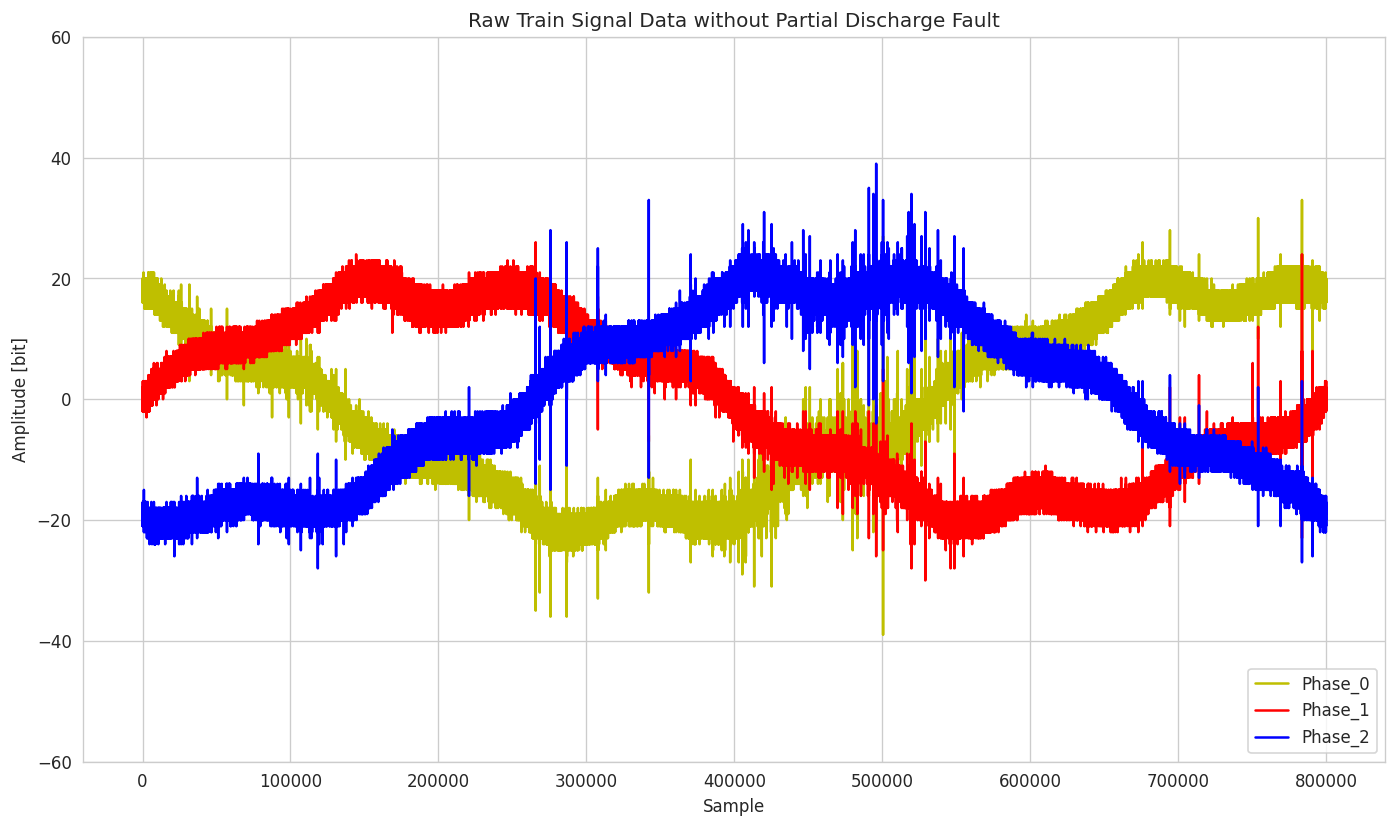

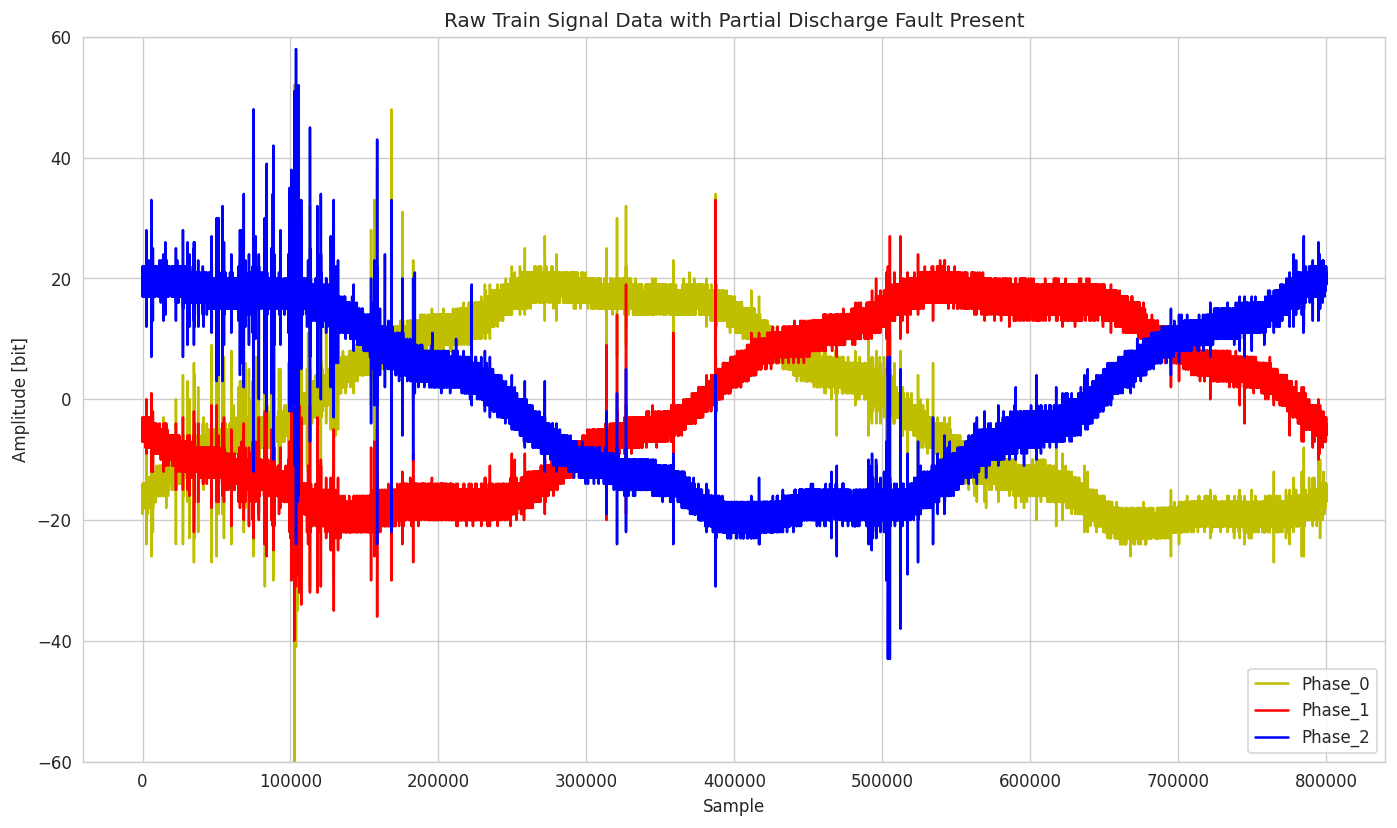

In [ ]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(plot_train))), plot_train["0"], '-', label=plot_labels[0], color='y')
plt.plot(list(range(len(plot_train))), plot_train["1"], '-', label=plot_labels[1], color='r')
plt.plot(list(range(len(plot_train))), plot_train["2"], '-', label=plot_labels[2], color='b')
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Train Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(plot_train))), plot_train["3"], '-', label=plot_labels[0], color='y')
plt.plot(list(range(len(plot_train))), plot_train["4"], '-', label=plot_labels[1], color='r')
plt.plot(list(range(len(plot_train))), plot_train["5"], '-', label=plot_labels[2], color='b')
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Train Signal Data with Partial Discharge Fault Present')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


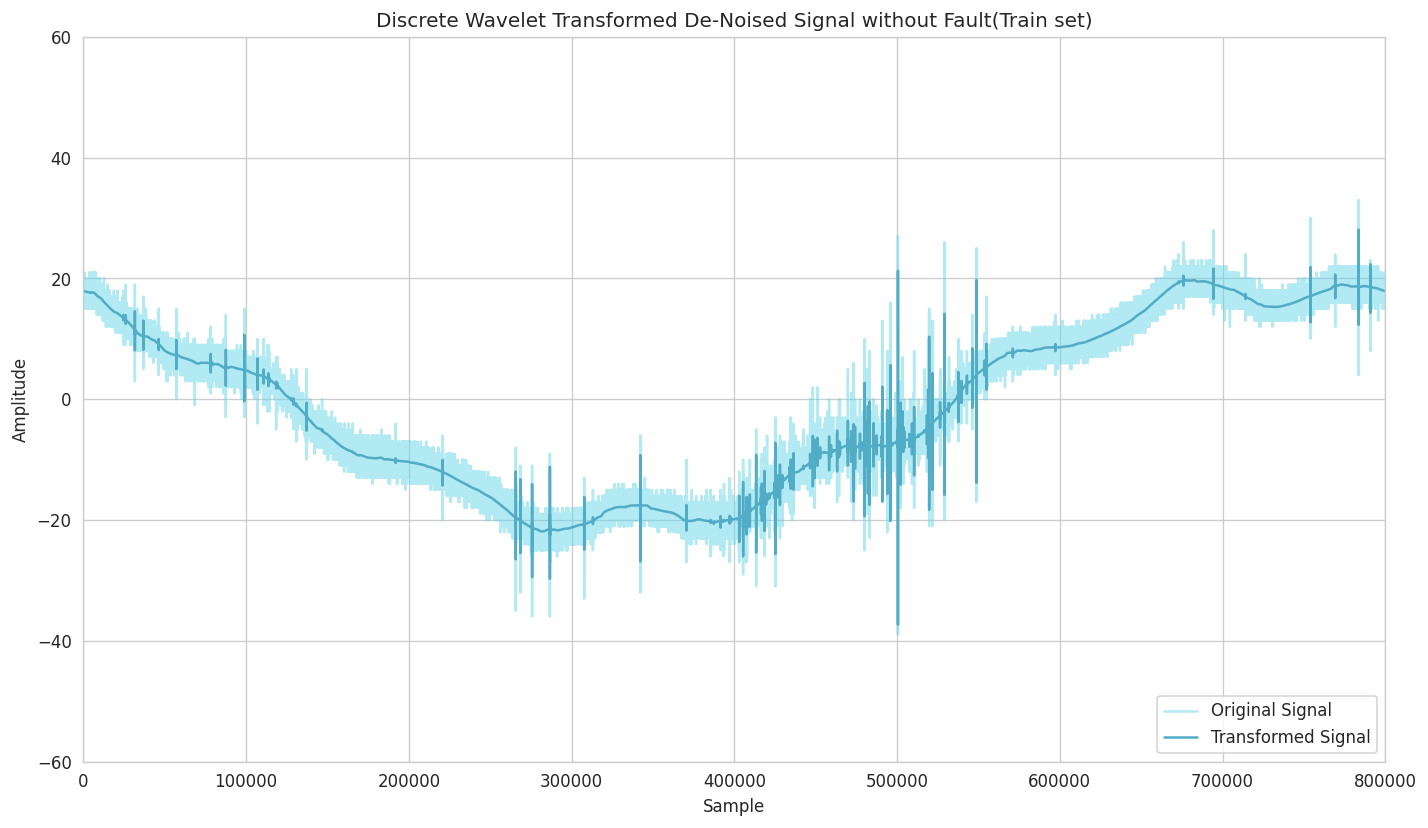

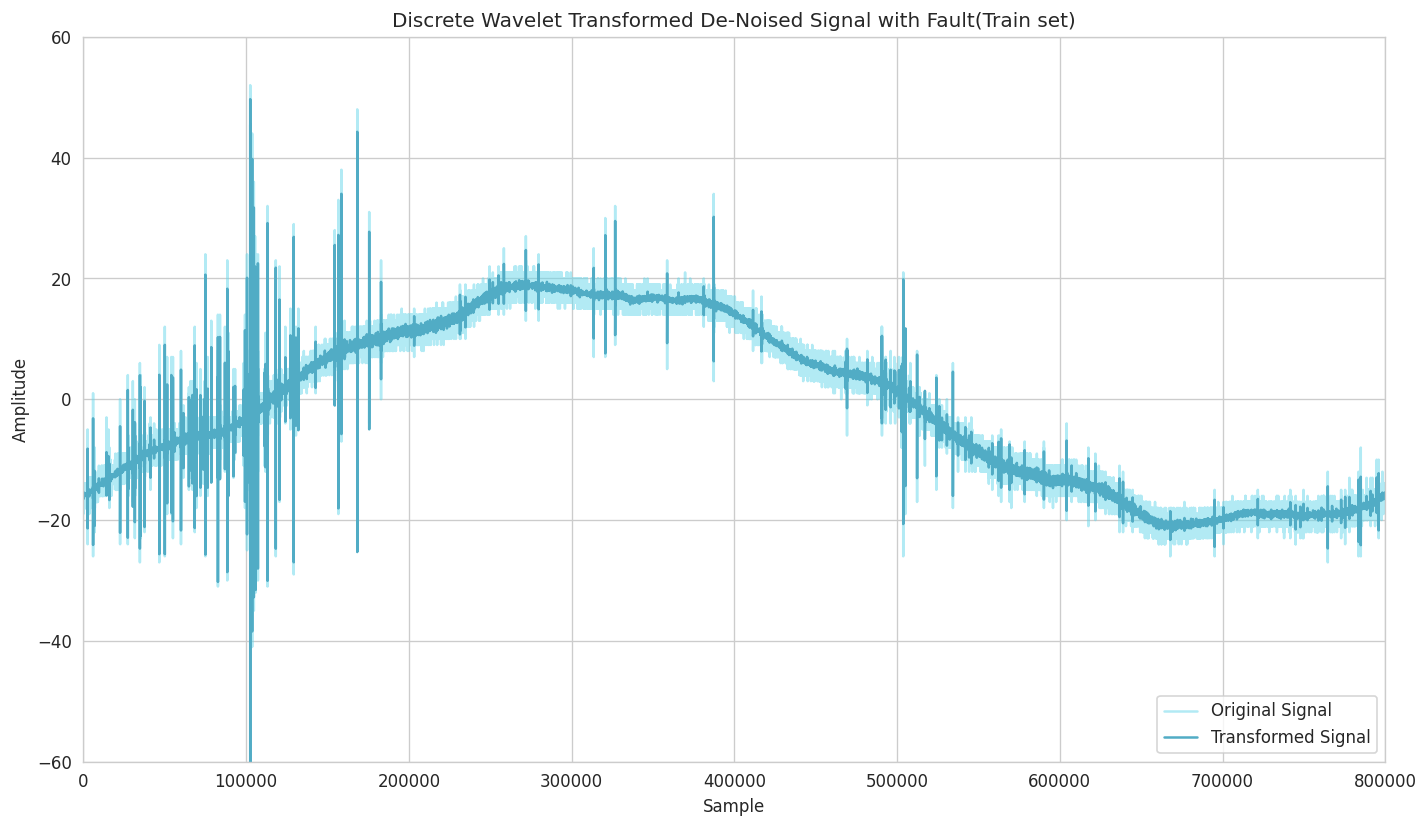

In [ ]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    #using discrete wavefrom transform(DWT)
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='y')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transformed De-Noised Signal without Fault(Train set)'
title1 = 'Discrete Wavelet Transformed De-Noised Signal with Fault(Train set)'
signal_0 =  waveSmooth(plot_train["0"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveSmooth(plot_train["3"], wavelet="db4", level=1, title=title1 )

In [ ]:
plot_test = pq.read_pandas("/content/drive/My Drive/datasets FINAL YEAR/test.parquet", columns=[str(i) for i in range(8800)]).to_pandas()

Text(0, 0.5, 'Amplitude [bit]')

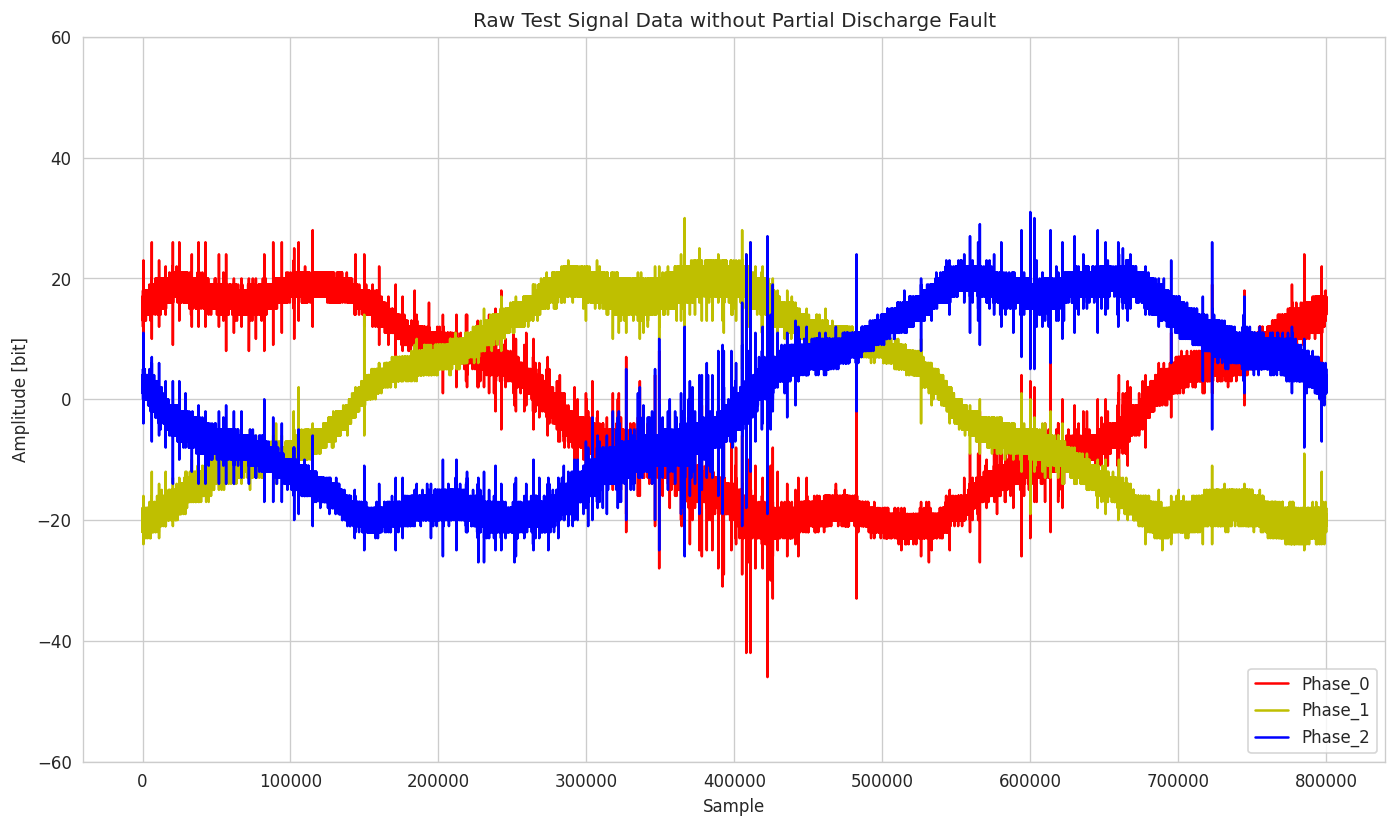

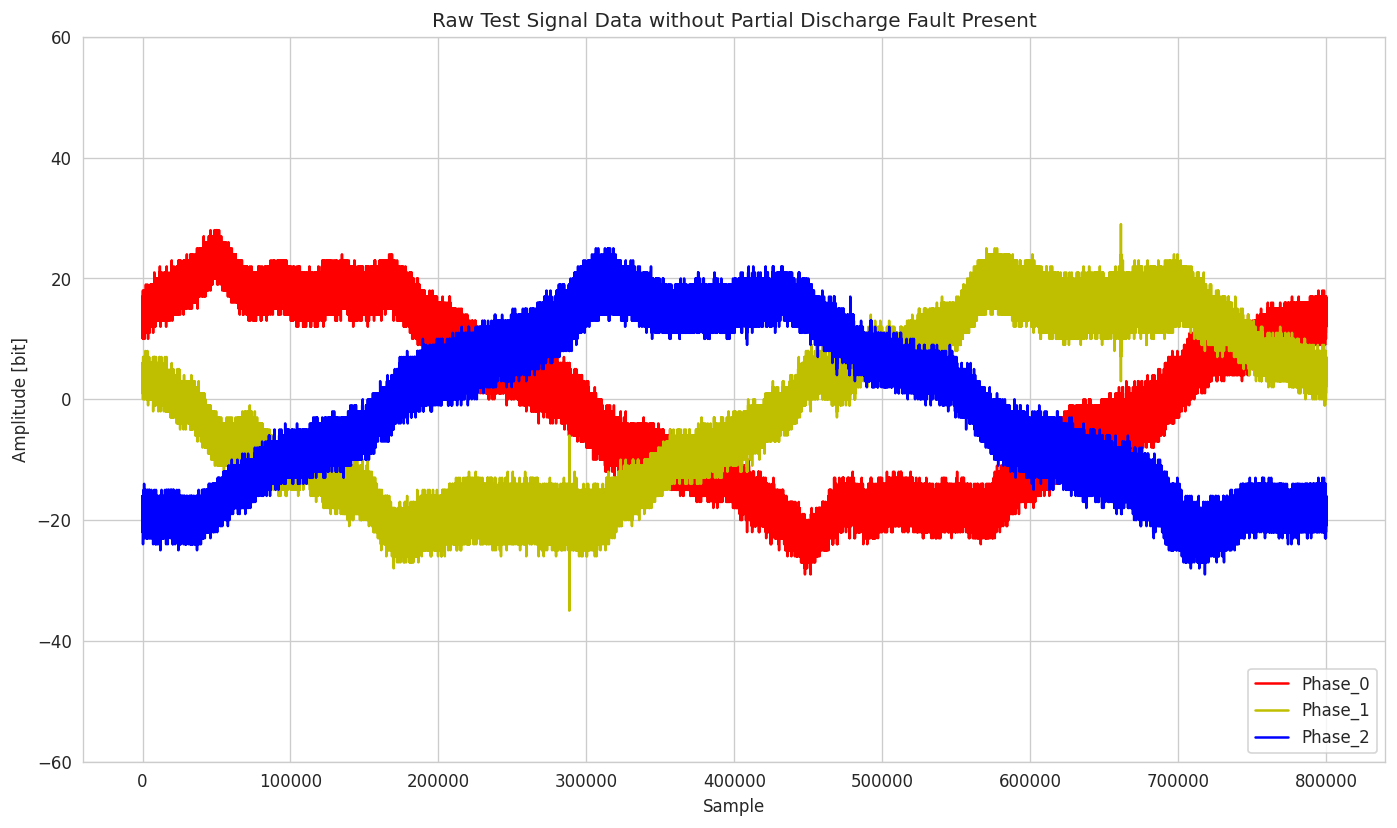

In [ ]:
#@title Default title text
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(plot_test))), plot_test["8712"], '-', label=plot_labels[0], color='r')
plt.plot(list(range(len(plot_test))), plot_test["8713"], '-', label=plot_labels[1], color='y')
plt.plot(list(range(len(plot_test))), plot_test["8714"], '-', label=plot_labels[2], color='b')
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Test Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(plot_test))), plot_test["8715"], '-', label=plot_labels[0], color='r')
plt.plot(list(range(len(plot_test))), plot_test["8716"], '-', label=plot_labels[1], color='y')
plt.plot(list(range(len(plot_test))), plot_test["8717"], '-', label=plot_labels[2], color='b')
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Test Signal Data without Partial Discharge Fault Present')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

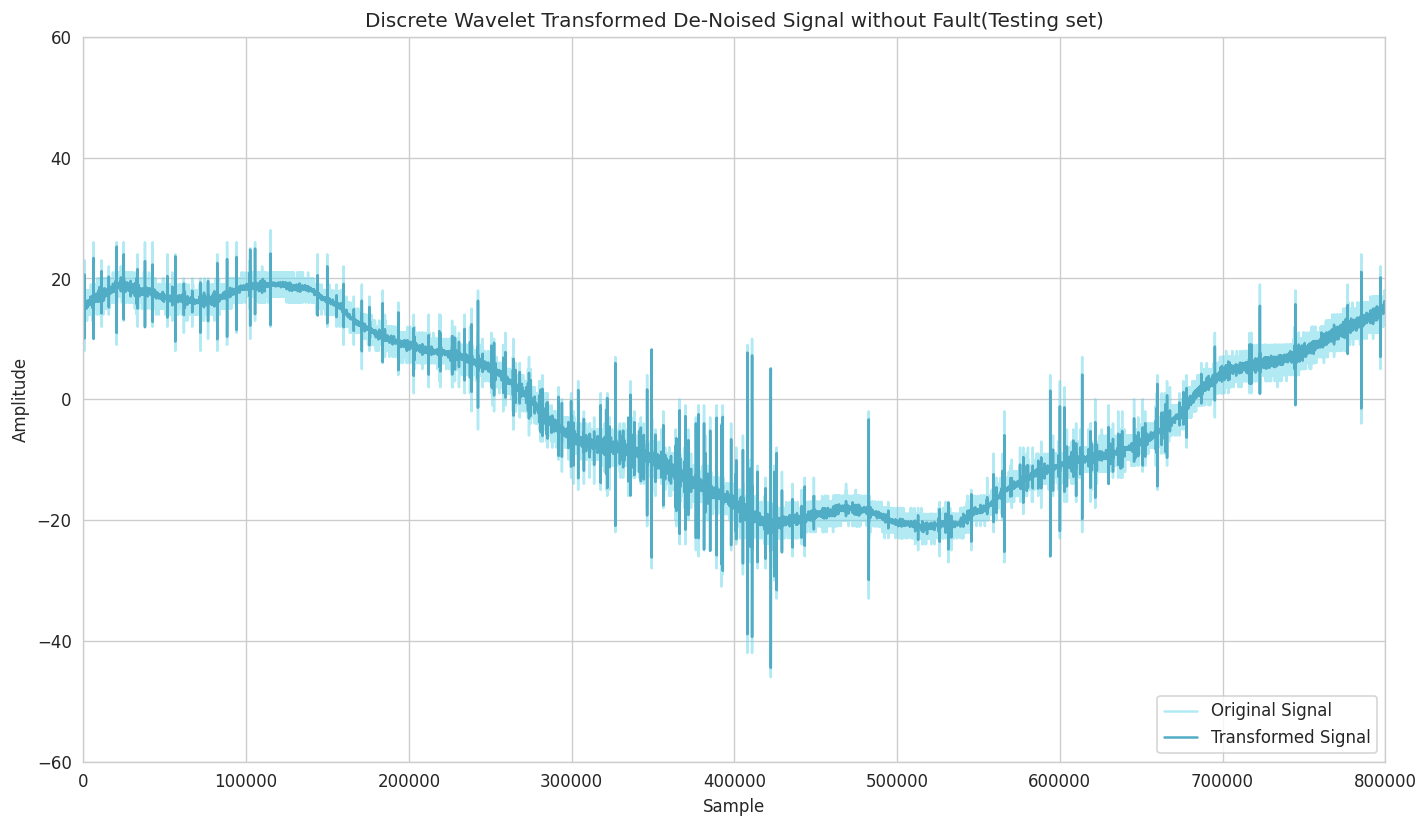

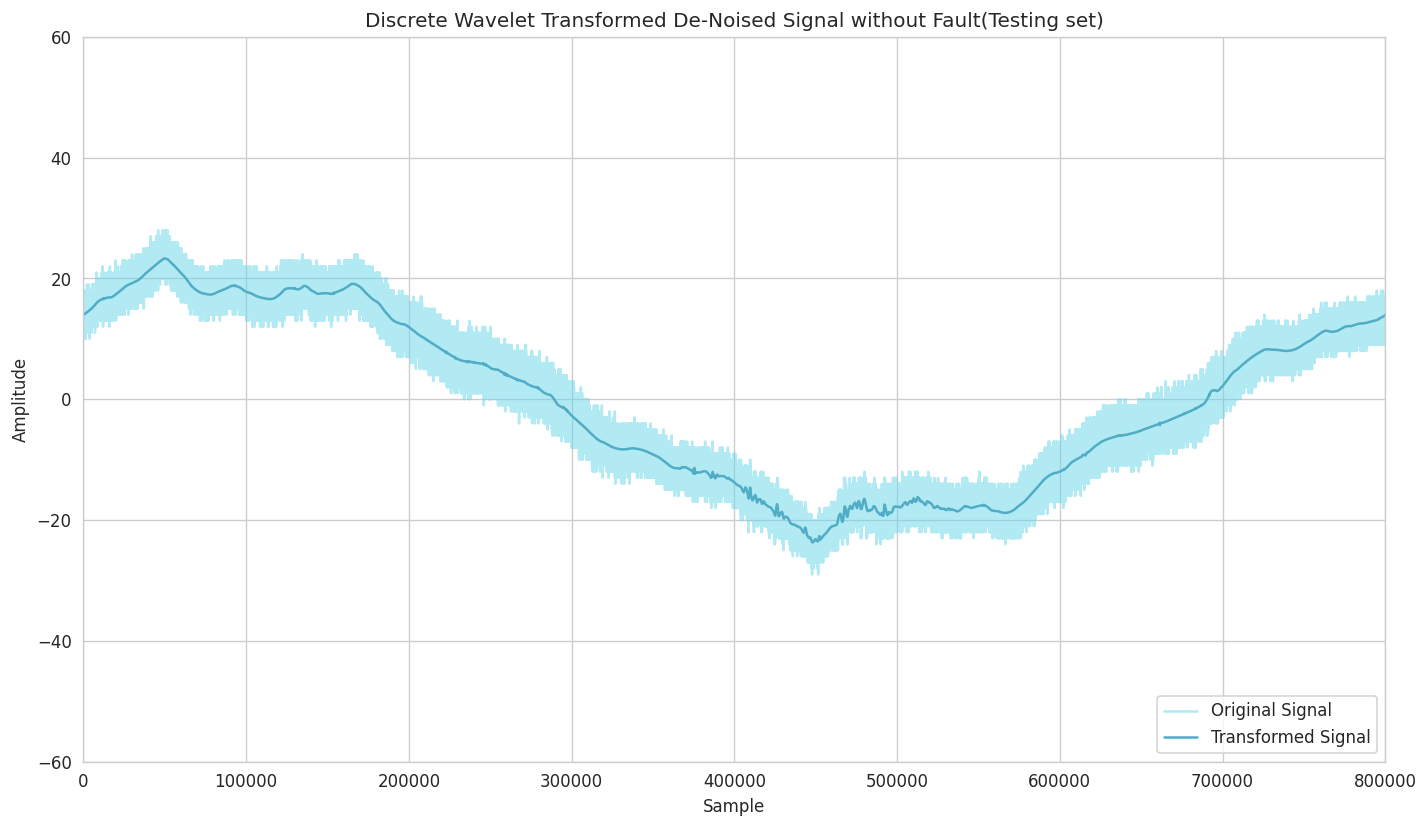

In [ ]:
title0 = 'Discrete Wavelet Transformed De-Noised Signal without Fault(Testing set)'
title1 = 'Discrete Wavelet Transformed De-Noised Signal without Fault(Testing set)'
signal_2 =  waveSmooth(plot_test["8712"], wavelet="db4", level=1, title=title0 )
signal_3 =  waveSmooth(plot_test["8715"], wavelet="db4", level=1, title=title1 )

In [16]:
from numpy.fft import *
from scipy import fftpack #fourier transform 

In [4]:
train_set = pq.read_pandas('/content/drive/My Drive/datasets FINAL YEAR/train.parquet').to_pandas()

In [5]:
meta_train = pd.read_csv('/content/drive/My Drive/datasets FINAL YEAR/metadata_train1.csv')

In [6]:
meta_train.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [17]:
#Acts as a Low pass filter to filter out HF components and get main signal profile
def low_pass(s, threshold=1e2):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [12]:
def phase_indices(signal_num):
    phase1 = 3*signal_num
    phase2 = 3*signal_num + 1
    phase3 = 3*signal_num + 2
    return phase1,phase2,phase3

In [13]:
s_id = 14
p1,p2,p3 = phase_indices(s_id)

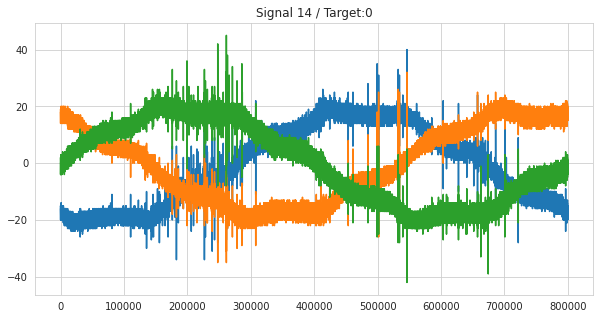

In [14]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(train_set.iloc[:,p1])
plt.plot(train_set.iloc[:,p2])
plt.plot(train_set.iloc[:,p3])

In [18]:
lf_signal_1 = low_pass(train_set.iloc[:,p1])
lf_signal_2 = low_pass(train_set.iloc[:,p2])
lf_signal_3 = low_pass(train_set.iloc[:,p3])


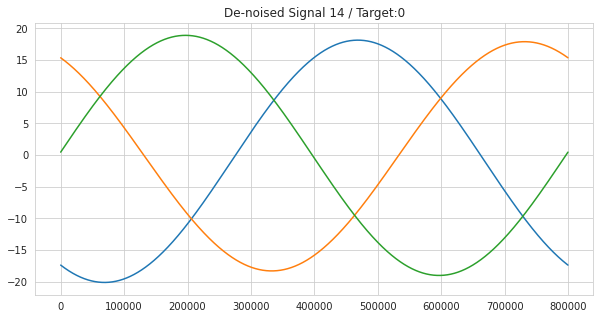

In [19]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)


In [26]:
###Acts as a High Pass Filter to filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [33]:
hf_signal_1 = high_pass(train_set.iloc[:,p1])
hf_signal_2 = high_pass(train_set.iloc[:,p2])
hf_signal_3 = high_pass(train_set.iloc[:,p3])

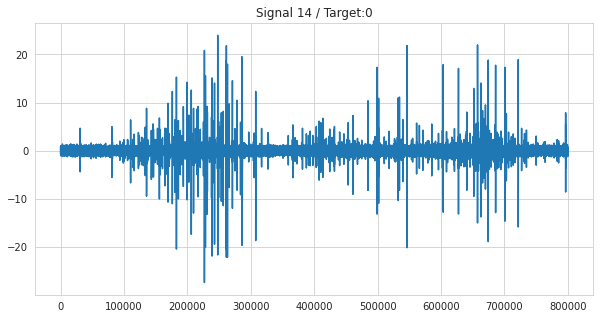

In [34]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1)

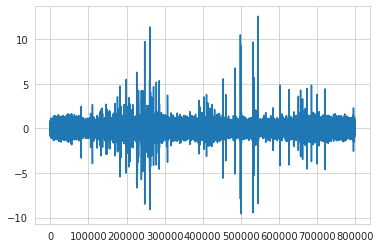

In [35]:
plt.plot(hf_signal_2)

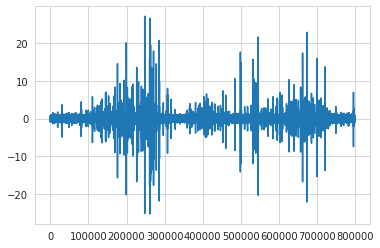

In [36]:
plt.plot(hf_signal_3)

In [37]:
@jit('float32(float32[:,:],int32)')
def feature_extractor(x, n_part=1000):
    lenght = len(x)
    pool = np.int32(np.ceil(lenght/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,lenght, pool)):
        if i+pool < lenght:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

<ipython-input-37-3f7c909140ea>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "feature_extractor" failed type inference due to: Invalid use of Function(<function amax at 0x7fa3e40e6510>) with argument(s) of type(s): (array(float32, 2d, A), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypingError: numba doesn't support kwarg for max
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/npydecl.py:402
In definition 1:
    TypingError: numba doesn't support kwarg for max
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/npydecl.py:402
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function amax at 0x7fa3e40e6510>)
[2] During: typing of call at <ipython-input-37-3f7c909140ea> (11)


File "<ipython-input-37-3f7c909140ea>", line 11:
def feature_extractor(x, n_part=1000):
    <source elide

In [38]:
x_train = []
y_train = []
for i in tqdm(meta_train.signal_id):
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train_set.iloc[:, idx].values, n_part=400)))

  0%|          | 0/8712 [00:00<?, ?it/s]<ipython-input-37-3f7c909140ea>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "feature_extractor" failed type inference due to: Invalid use of Function(<function amax at 0x7fa3e40e6510>) with argument(s) of type(s): (array(int8, 2d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypingError: numba doesn't support kwarg for max
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/npydecl.py:402
In definition 1:
    TypingError: numba doesn't support kwarg for max
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/npydecl.py:402
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function amax at 0x7fa3e40e6510>)
[2] During: typing of call at <ipython-input-37-3f7c909140ea> (11)


File "<ipython-input-37-3f7c909140ea>", line 11:
def feature_extr

In [39]:
del train_set; gc.collect()


46196

In [40]:
X_train = np.array(x_train).reshape(-1,x_train[0].shape[0])
y_train = np.array(y_train).reshape(-1,)


In [41]:
n_signals = 1 #So far each instance is one signal. We will diversify them in next step
n_outputs = 1 #Binary Classification

In [42]:
verbose, epochs, batch_size = True, 25, 16
n_steps, n_length = 40, 10
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(GRU(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [3]:
test_set = pq.read_pandas('/content/drive/My Drive/datasets FINAL YEAR/test.parquet').to_pandas()

In [44]:
meta_test=pd.read_csv('/content/drive/My Drive/datasets FINAL YEAR/metadata_test1.csv')

In [45]:
x_test=[]
y_test=[]
for i in tqdm(meta_test.signal_id.values):
  idx=i-8712
  clear_output(wait=True)
  x_test.append(abs(feature_extractor(test_set.iloc[:, idx].values, n_part=400)))
  y_test.append(meta_test.loc[meta_test.signal_id==idx, 'target'].values)


100%|██████████| 20337/20337 [03:52<00:00, 87.29it/s]


In [ ]:
sample=pd.read_csv('/content/drive/My Drive/datasets FINAL YEAR/sample_submission (1).csv')

In [46]:

del test_set; gc.collect()

32407

In [47]:
Y_test = np.array(y_test)
X_test = np.array(x_test)

In [48]:
Y_test = np.array(Y_test).reshape(-1,)
print(Y_test)

[array([], dtype=int64) array([], dtype=int64) array([], dtype=int64) ...
 array([0]) array([0]) array([0])]


In [49]:
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_signals))

In [52]:
L1_all=meta_test.drop(['target'],1)

In [53]:
target=meta_test.drop(['signal_id','id_measurement','phase'],1)

In [55]:
history = model.fit(X_train, y_train, validation_data=(X_test, target), epochs=50, verbose=verbose)

Train on 8712 samples, validate on 20337 samples
Epoch 1/50
8712/8712 [==============================] - 58s 7ms/step - loss: 0.2196 - accuracy: 0.9371 - val_loss: 0.1017 - val_accuracy: 0.9889
Epoch 2/50
8712/8712 [==============================] - 56s 6ms/step - loss: 0.1641 - accuracy: 0.9407 - val_loss: 0.0330 - val_accuracy: 0.9938
Epoch 3/50
8712/8712 [==============================] - 54s 6ms/step - loss: 0.1423 - accuracy: 0.9459 - val_loss: 0.0533 - val_accuracy: 0.9825
Epoch 4/50
8712/8712 [==============================] - 55s 6ms/step - loss: 0.1319 - accuracy: 0.9457 - val_loss: 0.0607 - val_accuracy: 0.9664
Epoch 5/50
8712/8712 [==============================] - 56s 6ms/step - loss: 0.1245 - accuracy: 0.9470 - val_loss: 0.0447 - val_accuracy: 0.9778
Epoch 6/50
8712/8712 [==============================] - 54s 6ms/step - loss: 0.1216 - accuracy: 0.9505 - val_loss: 0.0834 - val_accuracy: 0.9470
Epoch 7/50
8712/8712 [==============================] - 59s 7ms/step - loss: 0.11

In [56]:
pred = model.predict_classes(X_test)

In [ ]:
sample1 = np.array(sample).reshape(-1,)

In [57]:
threshpreds = (pred>0.5)*1

In [ ]:
L1_all

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1
...,...,...,...
20332,29044,9681,1
20333,29045,9681,2
20334,29046,9682,0
20335,29047,9682,1


In [ ]:
target

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
L1_all= np.squeeze(np.asarray(L1_all))
target= np.squeeze(np.asarray(target))

20337/20337 [==============================] - 14s 713us/step
Train: 0.998, Test: 0.974


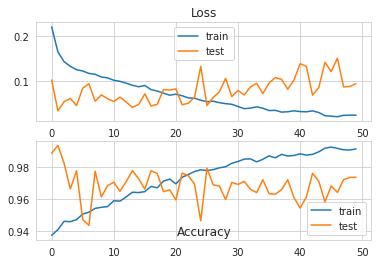

In [58]:
_, train_acc = model.evaluate(X_train, y_train, verbose=verbose)
_, test_acc = model.evaluate(X_test, target, verbose=verbose)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy', y=-0.01)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [59]:
def compare2(y_pred, model_name):
    test_values=[np.count_nonzero(target==0),np.count_nonzero(target==1)]
    pred_values=[np.count_nonzero(y_pred==0),np.count_nonzero(y_pred==1)]
    plt.figure()
    N=2
    width=0.35
    idx=np.arange(N)
    plt.bar(idx, test_values, width, label='True Vals')
    plt.bar(idx+width, pred_values, width, label='Predicted Vals')
    plt.ylabel('Number of Matches')
    plt.title(f'{model_name} Performance Measure per Category')
    plt.xticks(idx + width / 2, ('No fault', 'fault'))
    plt.legend(loc='best')
    plt.show()

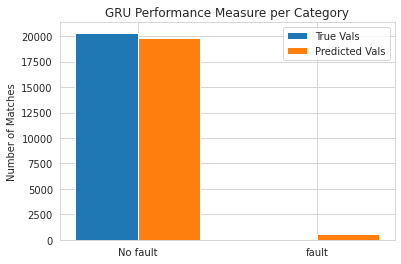

In [60]:
compare2(threshpreds, 'GRU')